In [1]:
import os
import sys
import time
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [14]:
from forward.runforward import run_local_coupling_forward
from spectrome import Brain, path, functions
from tqdm import trange

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi, SNPE_A
from sbi.utils.get_nn_models import posterior_nn
from sklearn.preprocessing import minmax_scale

import numpy as np
import xarray as xr
import dill
import pickle

### Some functions

In [3]:
def mag2db(y):
    """Convert magnitude response to decibels for a simple array.

    Args:
        y (numpy array): Power spectrum, raw magnitude response.

    Returns:
        dby (numpy array): Power spectrum in dB

    """
    dby = 20 * np.log10(y)
    return dby

stdPSDFn = lambda x: (x- x.mean(axis=1).reshape(-1, 1))/x.std(axis=1).reshape(-1, 1)

In [4]:
def network_transfer_local_alpha(C, D, parameters, w):
    """Network Transfer Function for spectral graph model.

    Args:
        brain (Brain): specific brain to calculate NTF
        parameters (dict): parameters for ntf. We shall keep this separate from Brain
        for now, as we want to change and update according to fitting.
        frequency (float): frequency at which to calculate NTF

    Returns:
        model_out (numpy asarray):  Each region's frequency response for
        the given frequency (w)
        frequency_response (numpy asarray):
        ev (numpy asarray): Eigen values
        Vv (numpy asarray): Eigen vectors

    """
    #C = brain.reducedConnectome
    #D = brain.distance_matrix

    
    parameters = np.asarray(parameters)
    tau_e = parameters[0]
    tau_i = parameters[1]
    tauC =  parameters[2]
    speed = parameters[3]
    alpha = parameters[4]
    gii =   parameters[5]  # inhibitory-inhibitory synaptic conductance as ratio of E-E syn
    gei =   parameters[6]  # excitatory-inhibitory synaptic conductance as ratio of E-E syn
    gee = 1
    
    # Defining some other parameters used:
    zero_thr = 0.05

    # define sum of degrees for rows and columns for laplacian normalization
    rowdegree = np.transpose(np.sum(C, axis=1))
    coldegree = np.sum(C, axis=0)
    qind = rowdegree + coldegree < 0.2 * np.mean(rowdegree + coldegree)
    rowdegree[qind] = np.inf
    coldegree[qind] = np.inf

    nroi = C.shape[0]

    K = nroi

    Tau = 0.001 * D / speed
    Cc = C * np.exp(-1j * Tau * w)

    # Eigen Decomposition of Complex Laplacian Here
    L1 = np.identity(nroi)
    L2 = np.divide(1, np.sqrt(np.multiply(rowdegree, coldegree)) + np.spacing(1))
    L = L1 - alpha * np.matmul(np.diag(L2), Cc)

    d, v = np.linalg.eig(L)  
    eig_ind = np.argsort(np.abs(d))  # sorting in ascending order and absolute value
    eig_vec = v[:, eig_ind]  # re-indexing eigen vectors according to sorted index
    eig_val = d[eig_ind]  # re-indexing eigen values with same sorted index

    eigenvalues = np.transpose(eig_val)
    eigenvectors = eig_vec[:, 0:K]

#     # Cortical model
    Fe = np.divide(1 / tau_e ** 2, (1j * w + 1 / tau_e) ** 2)
    Fi = np.divide(1 / tau_i ** 2, (1j * w + 1 / tau_i) ** 2)
    FG = np.divide(1 / tauC ** 2, (1j * w + 1 / tauC) ** 2)

    Hed = (1 + (Fe * Fi * gei)/(tau_e * (1j * w + Fi * gii/tau_i)))/(1j * w + Fe * gee/tau_e + (Fe * Fi * gei)**2/(tau_e * tau_i * (1j * w + Fi * gii / tau_i)))
    
    Hid = (1 - (Fe * Fi * gei)/(tau_i * (1j * w + Fe * gee/tau_e)))/(1j * w + Fi * gii/tau_i + (Fe * Fi * gei)**2/(tau_e * tau_i * (1j * w + Fe * gee / tau_e)))

    Htotal = Hed + Hid


#     q1 = (1j * w + 1 / tau_e * Fe * eigenvalues)
    q1 = (1j * w + 1 / tauC * FG * eigenvalues)
    qthr = zero_thr * np.abs(q1[:]).max()
    magq1 = np.maximum(np.abs(q1), qthr)
    angq1 = np.angle(q1)
    q1 = np.multiply(magq1, np.exp(1j * angq1))
    frequency_response = np.divide(Htotal, q1)
    
    model_out = 0

    for k in range(K):
        model_out += (frequency_response[k]) * np.outer(eigenvectors[:, k], np.conjugate(eigenvectors[:, k])) 
    model_out2 = np.linalg.norm(model_out,axis=1)

    
    return model_out2, frequency_response, eigenvalues, eigenvectors

class sgm:
    def __init__(self, C, D, freqs):
        self.freqs = freqs 
        self.C = C
        self.D = D
    def run_local_coupling_forward(self, params):
        """run_forward. Function for running the forward model over the passed in range of frequencies,
        for the handed set of parameters (which must be passed in as a dictionary)
    
        Args:
            brain (Brain): An instance of the Brain class.
            #C = brain.reducedConnectome
            #D = brain.distance_matrix
            params (dict): Dictionary of a setting of parameters for the NTF model.
            freqs (array): Array of freqencies for which the model is to be calculated.
    
        Returns:
            array: Model values for each frequency, for each region of the brain, ordered as according to HCP
            (as in Brain class ordering).
    
        """
    
        eigenvalues = []
        eigenvectors = []
        frequency_response = []
        model_out = []
    
        for freq in self.freqs:
            w = 2 * np.pi * freq
            freq_model, freq_resp, eig_val, eig_vec = network_transfer_local_alpha(
                self.C, self.D, params, w
            )
            frequency_response.append(freq_resp)
            eigenvalues.append(eig_val)
            eigenvectors.append(eig_vec)
            model_out.append(freq_model)
    
        frequency_response = np.asarray(frequency_response)
        eigenvalues = np.asarray(eigenvalues)
        eigenvectors = np.asarray(eigenvectors)
        model_out = np.transpose(np.asarray(model_out))
    
        return model_out, frequency_response, eigenvalues, eigenvectors

### Load real data PSD and brain

In [5]:
# Load data
ind_psd_xr = xr.open_dataarray('../data/individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
freqs = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray('../data/individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values


### Prepare for SBI

In [6]:
def para2res(params):
    sgmmodel = sgm(brain.reducedConnectome, brain.distance_matrix, freqs)
    psd, _, _, _  = sgmmodel.run_local_coupling_forward(params)
    psdDB = mag2db(np.abs(psd))
    stdPsdDB = stdPSDFn(psdDB)
    return stdPsdDB

def simulator(params):
    res = para2res(params)
    res = res[:68, :]
    noise =  np.random.randn(*res.shape)*0.1
    return (res + noise).flatten()

In [8]:
#for ix in range(10):
for ix in range(33, ind_conn.shape[-1]):
    print(ix)
    
    # obtain the brain
    curC = ind_conn[:, :, ix]
    data_dir = path.get_data_path()
    brain = Brain.Brain()
    brain.add_connectome(data_dir)
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome = curC
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()

    # taue, taui, tauC, speed, alpha, gii, gei
    par_low = np.asarray([0.005,0.005,0.005,5,0.1,0.1,0.1])
    par_high = np.asarray([0.02,0.02,0.02,20,1,5,5])
    prior = utils.BoxUniform(low=torch.as_tensor(par_low), high=torch.as_tensor(par_high))
    # make a SBI-wrapper on the simulator object for compatibility
    simulator_wrapper, prior = prepare_for_sbi(simulator, prior)
    
    numPrior = 10000
    theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=numPrior, num_workers=10)
    
    with open(f"./Prior_data_each_{numPrior}_{ix}.pkl", "wb") as f:
        pickle.dump([theta, x], f)
        
    inference = SNPE(prior=prior, density_estimator="mdn")
    density_estimator = inference.append_simulations(theta, x).train()
    
    posterior = inference.build_posterior(density_estimator)
    
    
    curX = torch.Tensor(stdPSDFn(mag2db(ind_psd[:, :, ix])).flatten())
    postSps = posterior.sample((10000, ), x=curX)
    
    with open(f"./PostSps_each_{numPrior}_{ix}.pkl", "wb") as f:
        pickle.dump(postSps, f)

33


Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 48 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

34


Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 65 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

35


Running 10000 simulations in 10000 batches.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 54 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

### Results

In [9]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [10]:
sortF = lambda p:int(p.stem.split("_")[-1])
fils = sorted(list(Path("./").glob("Post*10000*.pkl")), key=sortF)
postSpss = []
for fil in fils:
    with open(fil, "rb") as f:
        postSps = pickle.load(f)
    postSpss.append(postSps)

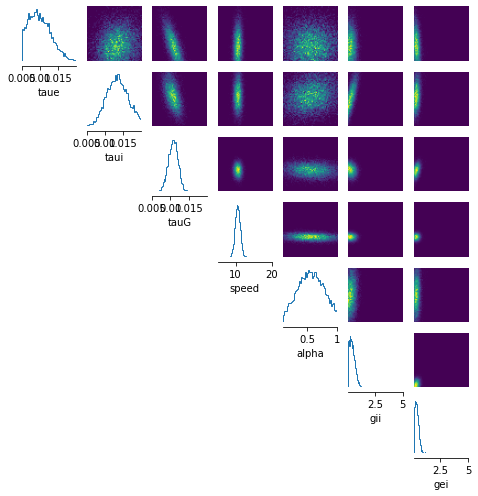

In [27]:
par_low = np.asarray([0.005,0.005,0.005,5,0.1,0.1,0.1])
par_high = np.asarray([0.02,0.02,0.02,20,1,5,5])
_ = analysis.pairplot(postSpss[0], limits=[[0.005,0.02],[0.005,0.02],[0.005,0.02],[5,20],[0.1,1],[0.1,5],[0.1,5]], labels=['taue','taui','tauG','speed','alpha','gii','gei'], figsize=(8,8))

In [11]:
# taue, taui, tauC, speed, alpha, gii, gei
postSpssNp = np.array([i.numpy() for i in postSpss])
mEstParas = postSpssNp.mean(axis=1)
mEstParas = np.median(postSpssNp, axis=1)

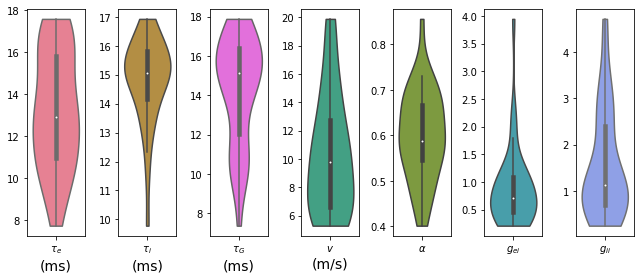

In [12]:
df=pd.DataFrame({r'$\tau_e$':mEstParas[:,0], 
                 r'$\tau_i$':mEstParas[:,1], 
                 r'$\tau_G$':mEstParas[:,2],
                 r'$v$'     :mEstParas[:,3], 
                 r'$\alpha$':mEstParas[:,4], 
                 r'$g_{ii}$':mEstParas[:,5], 
                 r'$g_{ei}$':mEstParas[:,6], 
                })

palette = sns.husl_palette(7) 

fig, ax = plt.subplots(1,7, num=1,  gridspec_kw={'width_ratios':[2,2,2,2,2,2,2]}, figsize=(9, 4))

sns.violinplot(data=df[[r'$\tau_e$']]*1000, ax=ax[0],color=palette[0],cut=0)
ax[0].set_xlabel('(ms)',fontsize=14)
sns.violinplot(data=df[[r'$\tau_i$']]*1000, ax=ax[1],color=palette[1],cut=0)
ax[1].set_xlabel('(ms)',fontsize=14)
sns.violinplot(data=df[[r'$\tau_G$']]*1000, ax=ax[2],color=palette[6],cut=0)
ax[2].set_xlabel('(ms)',fontsize=14)
sns.violinplot(data=df[[r'$v$']], ax=ax[3],color=palette[3],cut=0)
ax[3].set_xlabel('(m/s)',fontsize=14)
sns.violinplot(data=df[[r'$\alpha$']], ax=ax[4],color=palette[2],cut=0)
sns.violinplot(data=df[[r'$g_{ei}$']], ax=ax[5],color=palette[4],cut=0)
sns.violinplot(data=df[[r'$g_{ii}$']], ax=ax[6],color=palette[5],cut=0)
plt.tight_layout()

In [15]:
modelPsdCurs = []
for ix in trange(len(mEstParas)):
    curParas = mEstParas[ix, :]
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    curSgmModel = sgm(curBrain.reducedConnectome, curBrain.distance_matrix, freqs)
    curPsd, _, _, _  = curSgmModel.run_local_coupling_forward(curParas)
    curPsd = curPsd[:68, :]
    curPsdCur = mag2db(np.abs(curPsd)).mean(axis=0)
    modelPsdCurs.append(curPsdCur)
    
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:13<00:00,  2.68it/s]


In [25]:
#with open("./SGM_each_PSD_db.pkl", "wb") as f:
#     pickle.dump(modelPsdCurs, f)

In [21]:
modelPsdCur = np.array(modelPsdCurs).mean(axis=0)
expPsdCur =  mag2db(ind_psd).mean(axis=0)[:, :].mean(axis=-1)
modelPsdCur = np.mean(modelPsdCurs, axis=0)
expPsdCur =   np.mean(mag2db(ind_psd).mean(axis=0)[:, :], axis=-1)
#ix = 1
#modelPsdCur = np.array(modelPsdCurs)[ix, :]
#expPsdCur =  mag2db(ind_psd).mean(axis=0)[:, ix]

stdCur1 = (modelPsdCur - modelPsdCur.mean())/modelPsdCur.std()
stdCur2 = (expPsdCur - expPsdCur.mean())/expPsdCur.std()

Text(0, 0.5, 'Normalized PSD')

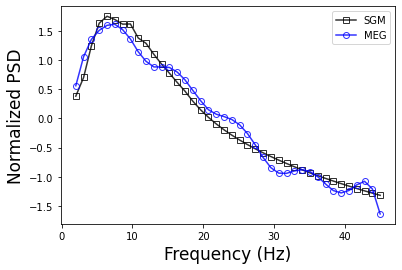

In [22]:
plt.plot(freqs, stdCur1, linestyle = '-',marker = 's',fillstyle = 'none',color = 'k', label = "SGM", alpha = 0.8)
plt.plot(freqs, stdCur2, linestyle = '-',marker = 'o',fillstyle = 'none',color = 'b', label = "MEG", alpha = 0.8)
plt.legend()
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)


In [24]:
stdCur2

array([ 0.56052281,  1.058434  ,  1.35593344,  1.50999223,  1.59545885,
        1.61394793,  1.52161745,  1.36141342,  1.14292832,  0.97932025,
        0.8833589 ,  0.88305699,  0.87400414,  0.7946595 ,  0.66025701,
        0.47971105,  0.30381389,  0.14936115,  0.07296581,  0.03230959,
       -0.01790955, -0.10976851, -0.25864088, -0.45219797, -0.66803307,
       -0.84315611, -0.93662455, -0.94026324, -0.90009021, -0.87810509,
       -0.90898572, -0.99707535, -1.12220985, -1.23520766, -1.27501312,
       -1.23406748, -1.13746248, -1.07647865, -1.20657823, -1.63519905])